<a href="https://colab.research.google.com/github/Kgs-Mathaba/NLP-sequential-sentence-classification-Project/blob/main/SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [100]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [101]:
# check what files in the pubmed_20k dataset
!ls pubmed-rct/PubMed_20k_RCT

dev.txt  test.txt  train.txt


In [102]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [103]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [104]:
 # Preprocess data
 # create a function to read lines of the document
def get_lines(filename):
  """

  Reads filename and return the lines of text as a list

  Args:
    filename: a string containing the target filepath.

  Returns:
    A list of strings with one string per line from the target filename
  """
  with open(filename, "r") as f:
    return f.readlines()

In [105]:
# read in training files
train_lines  = get_lines(data_dir+"train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [106]:
len(train_lines)

210040

In [107]:
# How should the data look
def preprocess_text_with_line_numbers(filename):
  """

  Returns a list of dictionaries of abstractt line data

  Takes in filename, reads its contents and sorts through each line, 
  extrating things like target label, text of the sentence,
  and how many sentences are in the current abstract and what sentence number
  target line is.
  """

  input_lines = get_lines(filename)
  abstract_lines = "" # create an empty abstact
  abstract_samples = [] # create an empty list of abstracts

  # Loop throught each line in target file
  for line in input_lines:
    if line.startswith('###'): #check to see if its an ID line
      abstract_id = line
      abstract_lines = " " # reset the abstract string if the line id an ID line

    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create an empty dictionary for each line
        target_text_split = abstract_line.split("\t") # split tatrget label form text
        line_data['target'] = target_text_split[0] # get target text and lower it
        line_data['text'] = target_text_split[1].lower() # get target text and lower it
        line_data['line_number'] = abstract_line_number #  what number does the line appear in the abstract?
        line_data['total_lines'] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? 
        abstract_samples.append(line_data)

    else: # if the abvoe condition aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples   

In [108]:
# Get data from file and preprocess it

%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 1.03 s, sys: 339 ms, total: 1.37 s
Wall time: 1.41 s


In [109]:
# check the first abstract from the training data
train_samples[:20]

[{'line_number': 0,
  'target': ' OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures includ

In [110]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(24)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [111]:
# Distribution of labels
train_df['target'].replace({" OBJECTIVE": "OBJECTIVE", " BACKGROUND": "BACKGROUND", " METHODS": "METHODS", " CONCLUSIONS": "CONCLUSIONS"}, inplace=True)
val_df['target'].replace({" OBJECTIVE": "OBJECTIVE", " BACKGROUND": "BACKGROUND", " METHODS": "METHODS", " CONCLUSIONS": "CONCLUSIONS"}, inplace=True)
test_df['target'].replace({" OBJECTIVE": "OBJECTIVE", " BACKGROUND": "BACKGROUND", " METHODS": "METHODS", " CONCLUSIONS": "CONCLUSIONS"}, inplace=True)

train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

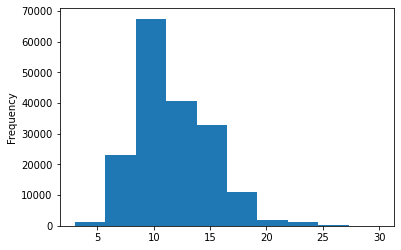

In [112]:
# Let's check the length of different lines

train_df.total_lines.plot.hist();

In [113]:
# convert abstract text lines into list
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [114]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [115]:
# Make numeric labels
# One hot encode labels

from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.fit_transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df['target'].to_numpy().reshape(-1, 1))


# check what it looks like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [116]:
# Extract labels and encode them into intergers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

# check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [117]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [118]:
## Model 0: Getting a baseline with Multinomial Naive Bayes

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ('tf-idf', TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [119]:
# Evaluate model on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [120]:
# Make some prediction with the bsaeline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [121]:
from helper_functions import calculate_results

# Calculate baseline results
baseline_results = calculate_results(y_true = val_labels_encoded,
                                     y_pred = baseline_preds)

baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [122]:
## Preparing the text data for deep sequence model
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [123]:
# How long is the sentence on average?

sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
avg_sent_lens

26.338269273494777

In [124]:
max(sent_lens), min(sent_lens)

(296, 1)

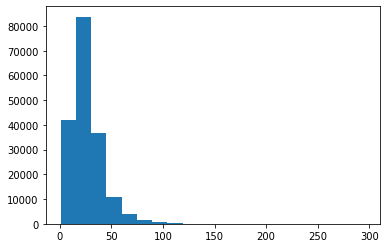

In [125]:
# What's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [126]:
# How long of a sentence length covers 95% of the examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [127]:
# Create text vectorizer layer (turn word to numbers)
# How many word are in the vocabulary (68K for 20K dataset)
max_tokens = 68000

# Create a text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_tokens, # number of words in vocabulary
                                    output_sequence_length = 55) # desired output of length of vectorized sequences

In [128]:
# Adapt text vectorizer to the training sentences
text_vectorizer.adapt(train_sentences)

In [129]:
# Test out text vectorizer on random sentence

import random
target_sentence = random.choice(train_sentences)
print(f'Text: \n {target_sentence}')
print(f'\n Length of text: {len(target_sentence)}')
print(f'\n Vectorized text: {text_vectorizer([target_sentence])}')

Text: 
 the d-cycloserine plus ct group showed a significant improvement in median tfi score ( -@ -lsb- @ % ci , -@ to -@ -rsb- ) and self-reported cognitive deficits ( -@ -lsb- @ % ci , -@ to -@ -rsb- ) , but the placebo group did not ( -@ -lsb- @ % ci , -@ to @ -rsb- and -@ -lsb- @ % ci , -@ to @ -rsb- , respectively ) .

 Length of text: 316

 Vectorized text: [[    2  8482   231   663    13   147     8    37   194     5   193 19464
    101    46    50     6    45     3   799   301  2673    46    50     6
     45    72     2    48    13   112    31    46    50     6    45     3
     46    50     6    45    83     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [130]:
# How many words are in the training vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in the vocab: {len(rct_20k_text_vocab)}')
print(f'Most comoon words in the vocab: {rct_20k_text_vocab[:5]}')
print(f'Least common words in the vocab: {rct_20k_text_vocab[-5:]}')

Number of words in the vocab: 64841
Most comoon words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [131]:
# Create custom text embedding ( this captures the relationship between the vectrized words)

token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocab
                               output_dim = 128, 
                               mask_zero = True, # to handle variable sequence lengths
                               name='token_embedding')


In [132]:
# show an example of embedding
print(f'Sentence before vectorization:\n {target_sentence}\n')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization (before embedding): \n {vectorized_sentence} \n')
embedding_sentence = token_embed(vectorized_sentence)
print(f'Sentence after embedding:\n {embedding_sentence}\n')
print(f'Embedding entence shape: {embedding_sentence.shape}')

Sentence before vectorization:
 the d-cycloserine plus ct group showed a significant improvement in median tfi score ( -@ -lsb- @ % ci , -@ to -@ -rsb- ) and self-reported cognitive deficits ( -@ -lsb- @ % ci , -@ to -@ -rsb- ) , but the placebo group did not ( -@ -lsb- @ % ci , -@ to @ -rsb- and -@ -lsb- @ % ci , -@ to @ -rsb- , respectively ) .

Sentence after vectorization (before embedding): 
 [[    2  8482   231   663    13   147     8    37   194     5   193 19464
    101    46    50     6    45     3   799   301  2673    46    50     6
     45    72     2    48    13   112    31    46    50     6    45     3
     46    50     6    45    83     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]] 

Sentence after embedding:
 [[[ 0.00438187 -0.0147437   0.01229192 ... -0.04456148  0.02571375
    0.00574399]
  [ 0.02189653  0.03411645 -0.03280357 ... -0.03253015  0.02315194
    0.0316723 ]
  [-0.01289371  0.01634158  0.01984232 ...  0.04045154 -0.0313

In [133]:
# Creating datasets (making the data load as fast aspossible)
# Turn data into tensorflow datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [134]:
train_labels_one_hot.shape, train_labels_one_hot[0]

((180040, 5), array([0., 0., 0., 1., 0.]))

In [135]:
# Take tensorSliceDataset and turn them into prefetch datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [136]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [137]:
# Model 2: Conv1D with token embeddings
# Create 1D conv model to process sequences

inputs = layers.Input(shape=(1,), dtype = tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # Condense the output of out feature vector from conv layer
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)


# Compile model
model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [138]:
model_1.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 55)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d_2 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_1   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_12 (Dense)            (None, 5)                 325 

In [139]:
train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [140]:
len(train_dataset)

5627

In [141]:
# Fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset))) 

Epoch 1/3
562/562 [==============================] - 69s 122ms/step - loss: 0.9236 - accuracy: 0.6347 - val_loss: 0.6862 - val_accuracy: 0.7354
Epoch 2/3
562/562 [==============================] - 66s 118ms/step - loss: 0.6578 - accuracy: 0.7573 - val_loss: 0.6331 - val_accuracy: 0.7723
Epoch 3/3
562/562 [==============================] - 67s 119ms/step - loss: 0.6180 - accuracy: 0.7736 - val_loss: 0.5962 - val_accuracy: 0.7842


In [142]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.5971 - accuracy: 0.7860


[0.5970924496650696, 0.7859790921211243]

In [143]:
# Mak predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

(array([[4.39667702e-01, 1.78133264e-01, 6.57139644e-02, 2.90442020e-01,
         2.60429773e-02],
        [4.06726092e-01, 3.04598898e-01, 1.19568044e-02, 2.67095447e-01,
         9.62273777e-03],
        [1.22368164e-01, 6.72380347e-03, 1.37276424e-03, 8.69489074e-01,
         4.61845520e-05],
        ...,
        [5.60151784e-06, 7.59444200e-04, 8.20148096e-04, 3.19088804e-06,
         9.98411536e-01],
        [5.56678846e-02, 4.52865988e-01, 9.22710672e-02, 5.73185869e-02,
         3.41876447e-01],
        [1.88868999e-01, 6.49362803e-01, 6.27962425e-02, 3.67434137e-02,
         6.22285344e-02]], dtype=float32), (30212, 5))

In [144]:
# convert pred probs into classes

model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [145]:
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

In [146]:
# calculate model 1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred = model_1_preds)
model_1_results

{'accuracy': 78.5979081159804,
 'f1': 0.7834702119512967,
 'precision': 0.7825042309466833,
 'recall': 0.7859790811598041}

In [147]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [148]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
this trial did not show the superiority of early nasoenteric tube feeding , as compared with an oral diet after @ hours , in reducing the rate of infection or death in patients with acute pancreatitis at high risk for complications .

Sentence after embedding:
[-0.04653738  0.0493579  -0.02496767 -0.06726915 -0.05712114 -0.04388686
  0.02819716 -0.01949919  0.07855086  0.00358552  0.08440415  0.02418802
  0.00538463 -0.02199811 -0.07755439  0.04634335 -0.08447489  0.06558038
 -0.0588961   0.07506967  0.01469669  0.0496149  -0.05784542 -0.02066168
  0.06254162  0.03599038 -0.06409234  0.00552383 -0.07800208 -0.01987224] (truncated output)...

Length of sentence embedding:
512


In [149]:
# Building and fitting an NLP feature extraction model using 
# pretrained embeddings
# Define feature extraction model
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) 
# tokenize text and create embedding of ache sequence (512 long vector)
x = layers.Dense(128, activation='relu')(pretrained_embedding)
# Can add more layers here if you want
outputs = layers.Dense(5, activation='softmax')(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name='model_2_USE_feature_extractor')

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics =['accuracy'])

In [150]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
 dense_14 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [151]:
# Fit model_2 to the data
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch = int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data= valid_dataset,
                              validation_steps = int(0.1*len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 16ms/step - loss: 0.9180 - accuracy: 0.6500 - val_loss: 0.7969 - val_accuracy: 0.6918
Epoch 2/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7682 - accuracy: 0.7018 - val_loss: 0.7550 - val_accuracy: 0.7035
Epoch 3/3
562/562 [==============================] - 8s 15ms/step - loss: 0.7522 - accuracy: 0.7119 - val_loss: 0.7394 - val_accuracy: 0.7124


In [152]:
# Evaluate on the whole validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 12s 12ms/step - loss: 0.7417 - accuracy: 0.7140


[0.7416654825210571, 0.7139878273010254]

In [153]:
# Make predictions with thw feature extraction model
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[3.8513008e-01, 4.0010253e-01, 2.3655517e-03, 2.0611194e-01,
        6.2898211e-03],
       [3.3981586e-01, 5.0804216e-01, 3.1963959e-03, 1.4688300e-01,
        2.0626031e-03],
       [2.4162431e-01, 1.6309538e-01, 2.1276765e-02, 5.3450900e-01,
        3.9494507e-02],
       ...,
       [1.6156856e-03, 4.4553261e-03, 5.3067081e-02, 8.6697156e-04,
        9.3999493e-01],
       [4.7582947e-03, 4.6435323e-02, 1.9668159e-01, 1.5315571e-03,
        7.5059330e-01],
       [1.8832226e-01, 3.1000531e-01, 4.5558465e-01, 4.8526037e-03,
        4.1235272e-02]], dtype=float32)

In [154]:
# Convert the predictions probabiliteis 
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 2])>

In [155]:
# Calculate results from TF Hub pretrained embeedings results on val dataser
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.39878194095061,
 'f1': 0.7107050573631752,
 'precision': 0.7145639587328972,
 'recall': 0.7139878194095062}

In [156]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [157]:
# Model 3: Conv1D with character embeddings
# Create a character level tokenizer
# Make function to split sentences into characters

def split_chars(text):
  return " ".join(list(text))

# Test splitting non-character level sequence into character
split_chars(random_training_sentence)

't h i s   t r i a l   d i d   n o t   s h o w   t h e   s u p e r i o r i t y   o f   e a r l y   n a s o e n t e r i c   t u b e   f e e d i n g   ,   a s   c o m p a r e d   w i t h   a n   o r a l   d i e t   a f t e r   @   h o u r s   ,   i n   r e d u c i n g   t h e   r a t e   o f   i n f e c t i o n   o r   d e a t h   i n   p a t i e n t s   w i t h   a c u t e   p a n c r e a t i t i s   a t   h i g h   r i s k   f o r   c o m p l i c a t i o n s   .'

In [158]:
# Split sequence level data into character level data
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [159]:
# Whats's the average character length?
char_lengths = [len(sentence) for sentence in train_sentences]
mean_char_length = np.mean(char_lengths)
mean_char_length

149.3662574983337

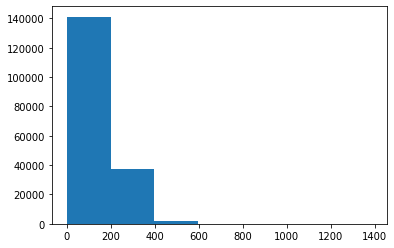

In [160]:
# Check the distribution of out sequences at a character-level
import matplotlib.pyplot as plt
plt.hist(char_lengths, bins=7);

In [161]:
# Find what characher length cover 95% of sequences
output_seq_char_len = int(np.percentile(char_lengths, 95))
output_seq_char_len

290

In [162]:
# Get all the keyboard characters
import string
alphabet = string.ascii_lowercase +string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [163]:
# create char level tokenizer
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of vocab tokrn)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length = output_seq_char_len,
                                    standardize=None,
                                    name='char_vectorizer')

In [164]:
# adapt char vectorizer to training character
char_vectorizer.adapt(train_chars)

In [165]:
# Check char vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f'Number of different character in vocabulary: {len(char_vocab)}')
print(f'5 most common characters: {char_vocab[:5]}')
print(f'5 least used characters: {char_vocab[-5:]}')

Number of different character in vocabulary: 57
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least used characters: ['|', '"', ']', '\\', '[']


In [166]:
# Test out char vectorizer
random_train_chars = random.choice(train_chars)
print(f'Charified text: \n {random_train_chars}')
print(f'Lengthof random_train_chars: {len(random_train_chars)}')
vectorized_chars = char_vectorizer([random_train_chars])
print(f'Vectorized text: \n {vectorized_chars}')
print(f'Length of vectorized chars: {len(vectorized_chars[0])}')

Charified text: 
 s b p   ,   d b p   ,   v o @ m a x   a n d   p p   w e r e   a s s e s s e d   .
Lengthof random_train_chars: 81
Vectorized text: 
 [[ 9 23 14 24 10 23 14 24 22  7 19 15  5 30  5  6 10 14 14 21  2  8  2  5
   9  9  2  9  9  2 10 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0 

In [167]:
# Create char embed layer
char_embed = layers.Embedding(input_dim=len(char_vocab), # number of different chars
                              output_dim = 25, # This is the size of char embedding in the paper
                              mask_zero = True,
                              name = 'char_embed')

In [168]:
# Test out char embed layer
print(f' Chars text:\n {random_train_chars}\n')
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f' Embedded chars (after vectorization and embedding):\n {char_embed_example}')
print(f'Char embed shape: {char_embed_example.shape}')

 Chars text:
 s b p   ,   d b p   ,   v o @ m a x   a n d   p p   w e r e   a s s e s s e d   .

 Embedded chars (after vectorization and embedding):
 [[[ 0.04324872 -0.02495517 -0.04775872 ... -0.03099436  0.02699811
    0.02932861]
  [ 0.00397599  0.0457758  -0.03841599 ...  0.04017792 -0.04995213
    0.03767128]
  [ 0.01814033  0.00913844 -0.02006528 ...  0.04128318  0.037761
   -0.04423281]
  ...
  [-0.01947384 -0.03016295 -0.01718308 ... -0.00117229 -0.03866491
   -0.00402888]
  [-0.01947384 -0.03016295 -0.01718308 ... -0.00117229 -0.03866491
   -0.00402888]
  [-0.01947384 -0.03016295 -0.01718308 ... -0.00117229 -0.03866491
   -0.00402888]]]
Char embed shape: (1, 290, 25)


In [169]:
# Building a Conv1D model to fit the character embeddings
# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(char_embeddings)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                          outputs=outputs,
                          name = 'model_2_char_embed')

# Compile the model
model_3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics='accuracy')

In [170]:
model_3.summary()

Model: "model_2_char_embed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1425      
                                                                 
 conv1d_3 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_15 (Dense)            (None, 5)          

In [171]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,
                                                        train_labels_one_hot
                                                         )).batch(32).prefetch(tf.data.AUTOTUNE)

val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,
                                                        val_labels_one_hot
                                                         )).batch(32).prefetch(tf.data.AUTOTUNE)    

test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,
                                                        test_labels_one_hot
                                                         )).batch(32).prefetch(tf.data.AUTOTUNE)                                                                                                          

In [172]:
train_char_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [173]:
# Fit model
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch = int(0.1*len(train_char_dataset)),
                              epochs=3,
                              validation_data = val_char_dataset,
                              validation_steps = int(0.1*len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 19s 32ms/step - loss: 1.1733 - accuracy: 0.5373 - val_loss: 0.9410 - val_accuracy: 0.6340
Epoch 2/3
562/562 [==============================] - 18s 31ms/step - loss: 0.9030 - accuracy: 0.6410 - val_loss: 0.8606 - val_accuracy: 0.6666
Epoch 3/3
562/562 [==============================] - 17s 31ms/step - loss: 0.8448 - accuracy: 0.6675 - val_loss: 0.8056 - val_accuracy: 0.6905


In [174]:
# Make predictions with model_3
model_3_pred_prob = model_3.predict(val_char_dataset)
model_3_pred_prob

array([[0.19067457, 0.34560707, 0.21831335, 0.18453518, 0.06086983],
       [0.35024604, 0.33574888, 0.05261847, 0.16047564, 0.10091101],
       [0.12572333, 0.40707025, 0.268299  , 0.13508001, 0.06382744],
       ...,
       [0.00733815, 0.00417763, 0.08702847, 0.01970172, 0.8817541 ],
       [0.00940416, 0.08714539, 0.12707451, 0.00577339, 0.7706026 ],
       [0.58210254, 0.17688325, 0.1540879 , 0.06897058, 0.01795564]],
      dtype=float32)

In [175]:
# Convert predictions probabilitites to class labels
model_3_preds = tf.argmax(model_3_pred_prob, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 0, 1, ..., 4, 4, 0])>

In [176]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)

model_3_results

{'accuracy': 68.6780087382497,
 'f1': 0.6769594250104388,
 'precision': 0.6879985562574339,
 'recall': 0.6867800873824971}

In [177]:
baseline_results

{'accuracy': 72.1832384482987,
 'f1': 0.6989250353450294,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869}

In [178]:
# Model 4: Combining pretrained token embedding + char embedding ( hybrid embedding layer)

# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name = 'token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-lstm shown in figure 1 of the paper
char_model = tf.keras.Model(inputs = char_inputs,
                            outputs = char_bi_lstm)

# 3. Concatenate token and char inputs ( creates hybrid token embedding)
token_char_concat = layers.Concatenate(name = 'token_char_hybrid')([token_model.output,
                                                                    char_model.output])

# 4. Create output layers with dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation='softmax')(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs = [token_model.input, char_model.input],
                         outputs = output_layer,
                         name = 'model_4_token_char_embeddings')

In [179]:
model_4.summary()

Model: "model_4_token_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['tok

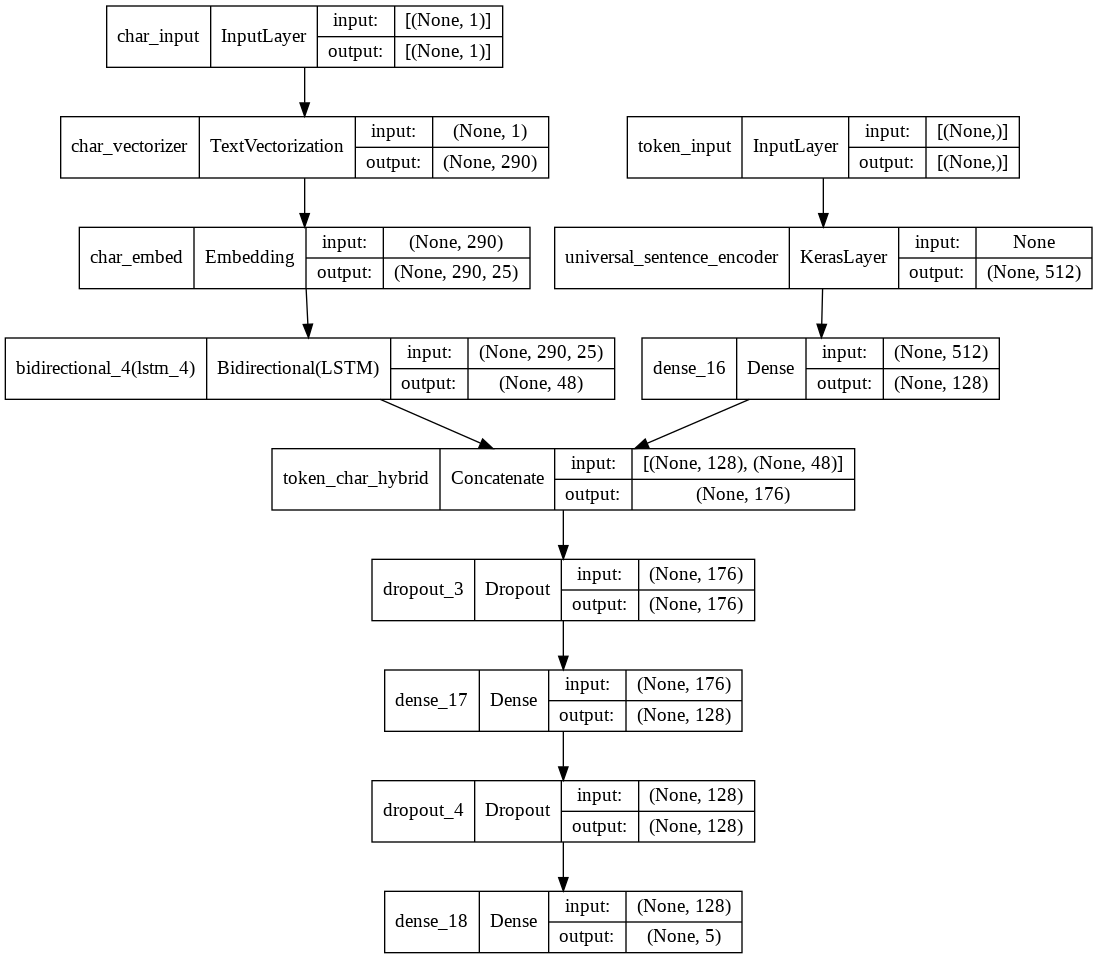

In [180]:
tf.keras.utils.plot_model(model_4, "model_4_token_char_embeddings.png", show_shapes=True)

In [181]:
# Compile token char model
model_4.compile(loss='categorical_crossentropy',
                optimizer = 'adam',
                metrics=['accuracy'])

In [186]:
# Combining token and char data into tf.data Dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))
# prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# repeat for validation dataset
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars)) # make data
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot) # make labels
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
# prefetch and batch valid data
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [187]:
train_char_token_dataset, val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

In [201]:
# Fitting the model on token and char level sequences
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch = int(0.1*len(train_char_token_dataset)),
                              epochs=3,
                              validation_data = val_char_token_dataset,
                              validation_steps = int(0.1*len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 194s 346ms/step - loss: 0.7382 - accuracy: 0.7220 - val_loss: 0.6669 - val_accuracy: 0.7480
Epoch 2/3
562/562 [==============================] - 194s 346ms/step - loss: 0.7041 - accuracy: 0.7376 - val_loss: 0.6546 - val_accuracy: 0.7503
Epoch 3/3
562/562 [==============================] - 195s 347ms/step - loss: 0.6996 - accuracy: 0.7337 - val_loss: 0.6455 - val_accuracy: 0.7557


In [202]:
# Evaluate on the whole dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 61s 65ms/step - loss: 0.6447 - accuracy: 0.7549


[0.6447184085845947, 0.7548655867576599]

In [203]:
# Make predictions using the token-char model
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

array([[5.3981024e-01, 2.3781006e-01, 7.4440008e-04, 2.1918374e-01,
        2.4515789e-03],
       [3.8003698e-01, 4.2148820e-01, 1.1150759e-03, 1.9564234e-01,
        1.7173690e-03],
       [2.8392285e-01, 5.9352417e-02, 2.2653334e-02, 6.1738265e-01,
        1.6688831e-02],
       ...,
       [1.5902019e-04, 2.1178147e-03, 3.7002914e-02, 2.5620464e-05,
        9.6069467e-01],
       [2.1809440e-02, 1.5050814e-01, 2.2653848e-01, 9.1365268e-03,
        5.9200746e-01],
       [3.6066589e-01, 5.2779567e-01, 8.0315590e-02, 1.2185960e-02,
        1.9036913e-02]], dtype=float32)

In [204]:
# Format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [205]:
# get the results of token char model
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results

{'accuracy': 75.48656163113995,
 'f1': 0.7532188537873241,
 'precision': 0.7545425783376193,
 'recall': 0.7548656163113995}

In [207]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [210]:
# Create positional embeddings
# How mant line number are there?
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

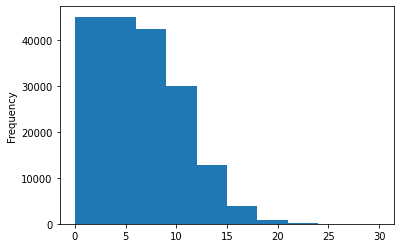

In [220]:
# Check distibution of line number column
train_df.line_number.plot.hist()

In [221]:
# Use tensorflow to crate one hot encoded tensors of line number
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(), depth=15) # keep it at 15D to prevent the curse of dimensionality
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [222]:
# Encode total lines feature
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

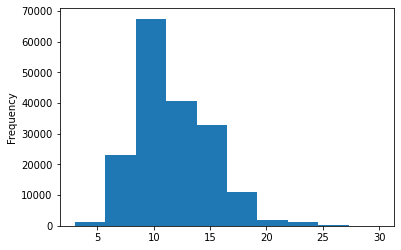

In [223]:
train_df.total_lines.plot.hist()

In [224]:
# check the coverage of a 'total lines' value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [225]:
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)

train_total_lines_one_hot[:10], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0